## Set Up and Import Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = 'Weather Training Data.csv'
df = pd.read_csv(data)
df.head()

,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0


## Data cleaning and EDA

In [3]:
# Find all categorical variables
categorical = df.select_dtypes(include=['object']).columns.tolist()

# Count the binary categorical variables
binary_categorical = [col for col in categorical if df[col].nunique() == 2]

# Print the list of categorical variables
print(categorical)

# Print the count and names of binary categorical variables
print(len(binary_categorical), binary_categorical)

['row ID', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
1 ['RainToday']


### Check for null values.

In [4]:
# Check for missing values in categorical variables
missing_categorical = df[categorical].isnull().sum()

# Filter the categorical variables with missing values
categorical_with_missing = missing_categorical[missing_categorical > 0]

# Print the categorical variables with missing values
print(categorical_with_missing)

WindGustDir    6521
WindDir9am     7006
WindDir3pm     2648
RainToday       979
dtype: int64


### Find numerical columns and identify outliers

In [5]:
# Find all numerical variables by excluding object (categorical) variables
numerical = df.select_dtypes(exclude=['object']).columns.tolist()

# Print the list of numerical variables
print(numerical)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTomorrow']


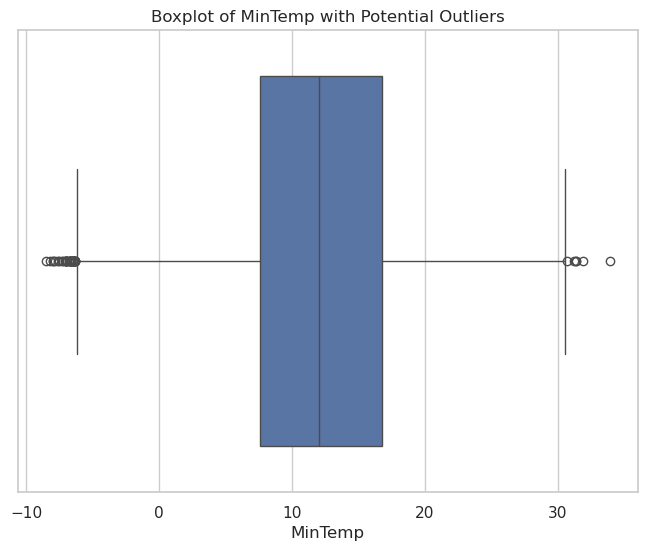

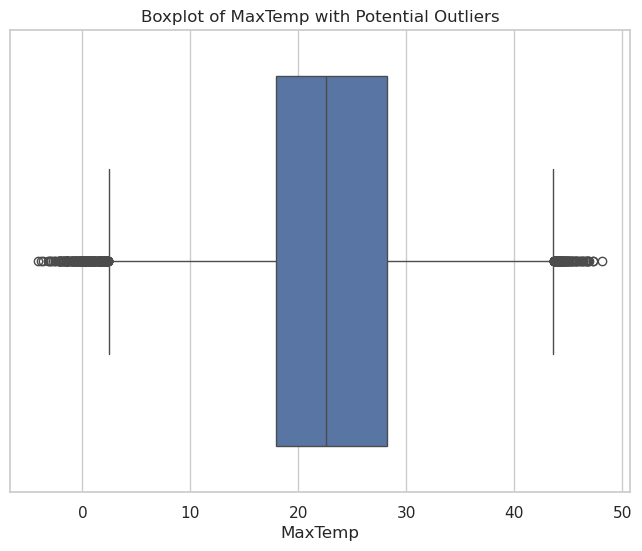

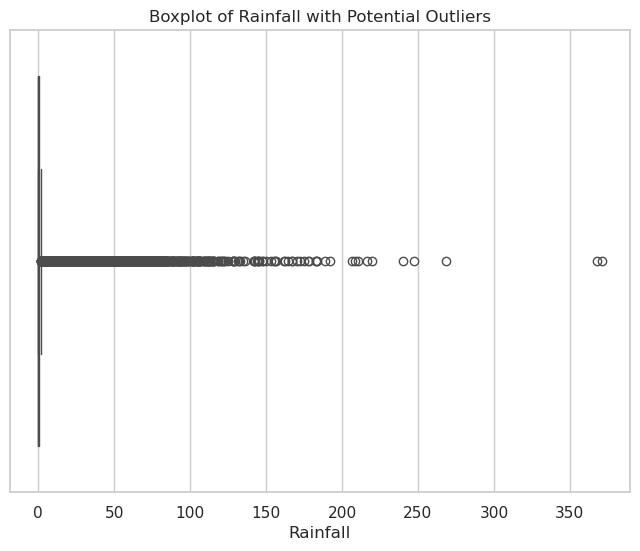

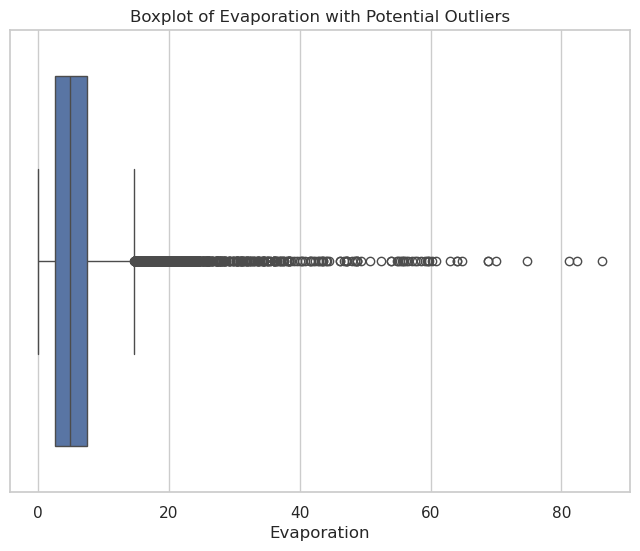

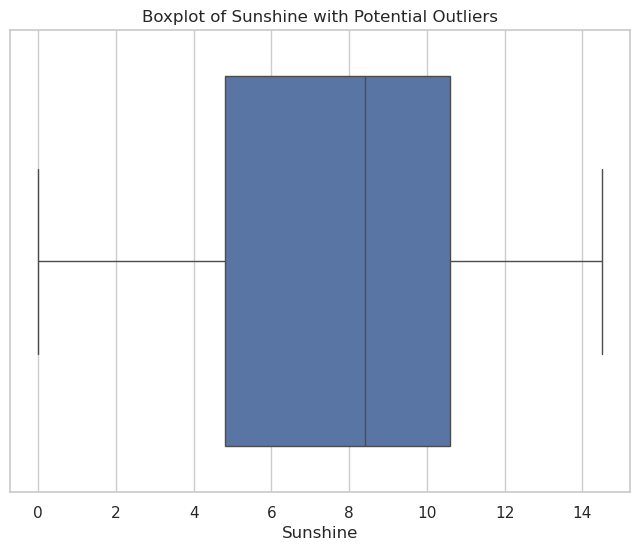

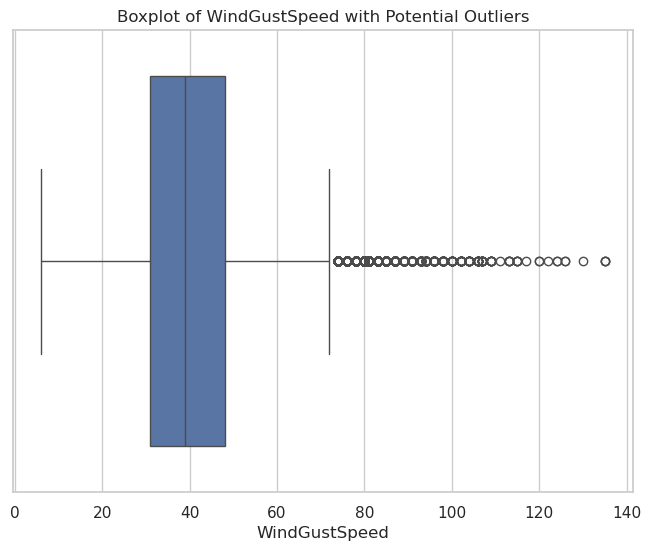

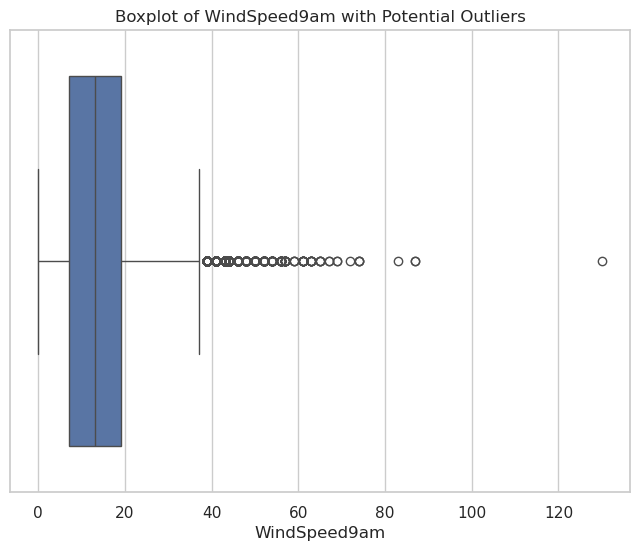

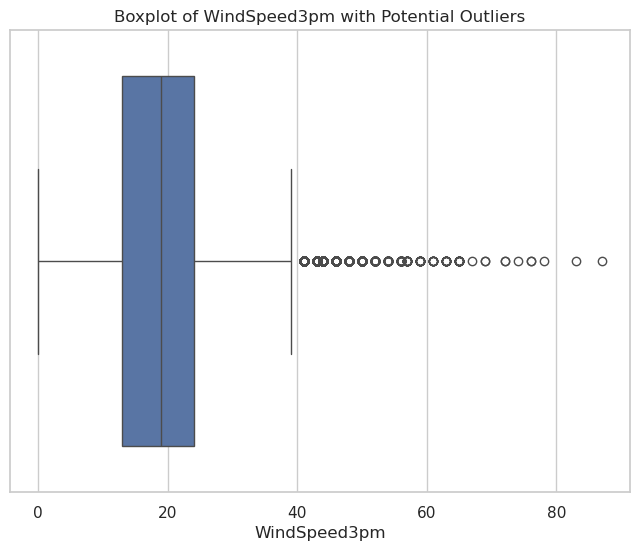

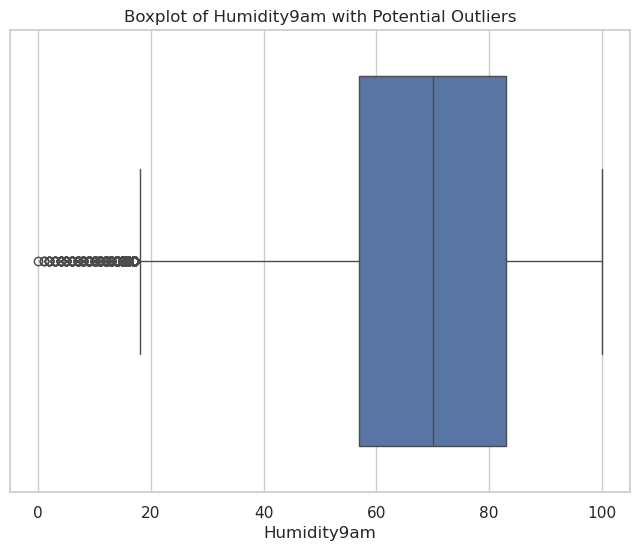

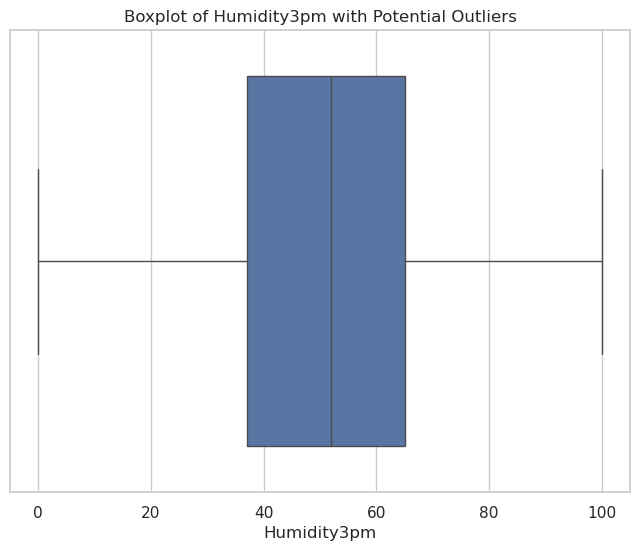

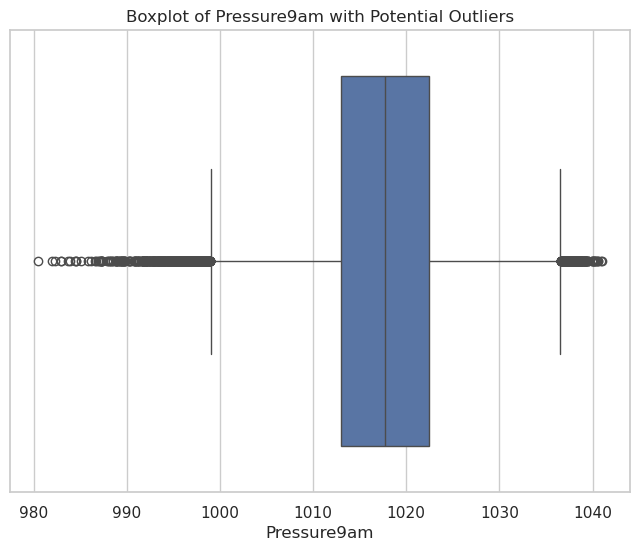

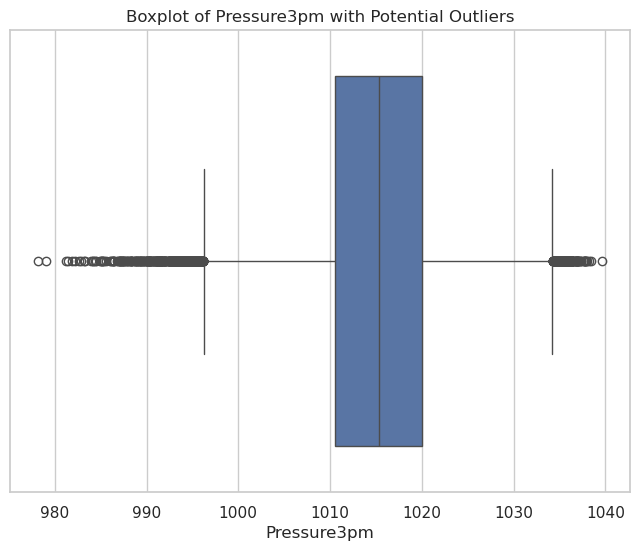

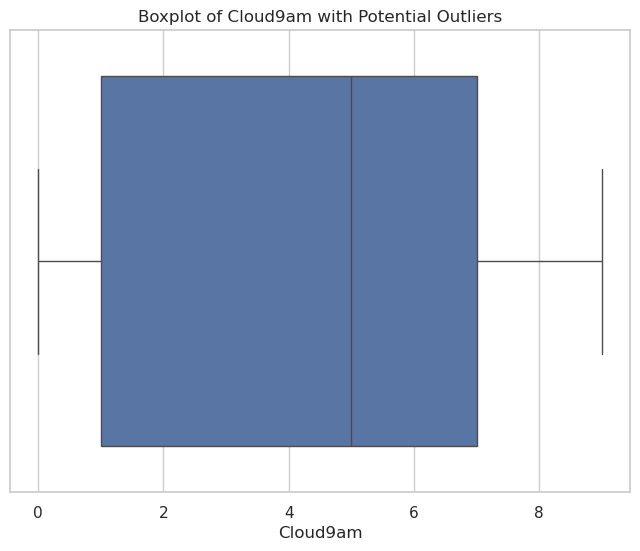

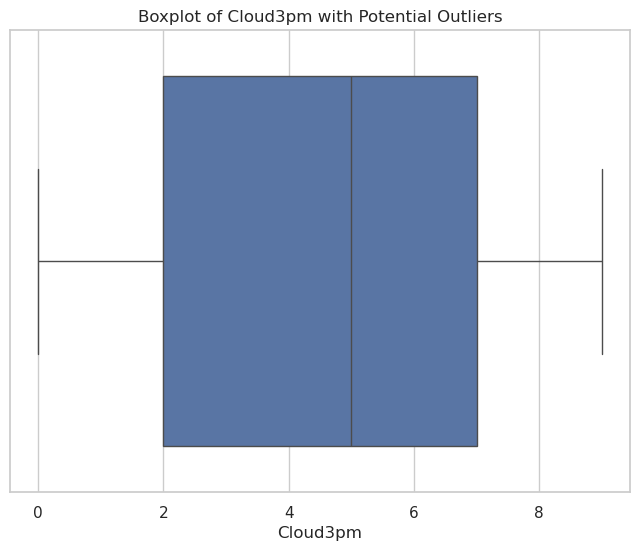

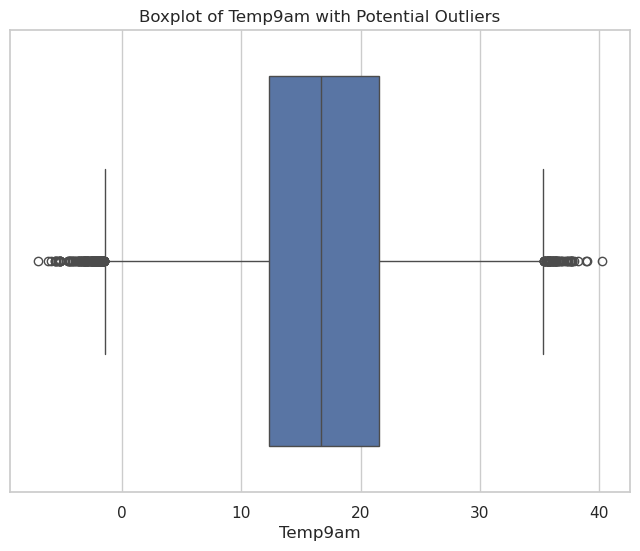

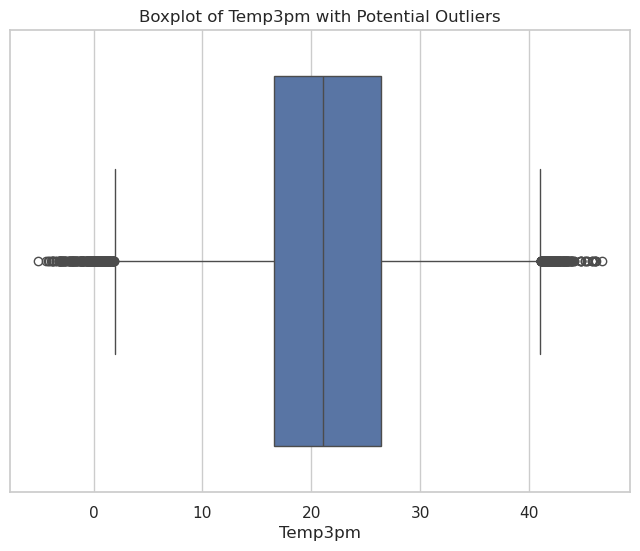

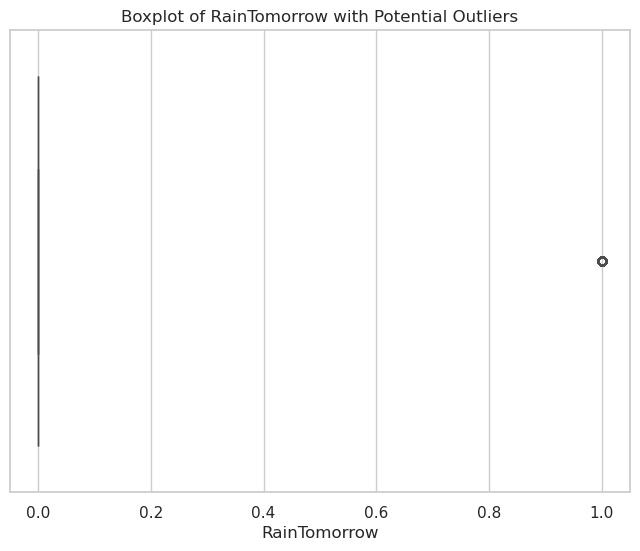

Numerical Variables with Potential Outliers:
MinTemp
MaxTemp
Rainfall
Evaporation
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Pressure9am
Pressure3pm
Temp9am
Temp3pm
RainTomorrow


In [6]:
# Initialize a dictionary to store potential outliers
potential_outliers = {}

# Function to identify and plot outliers for numerical columns
for col in numerical:
    # Calculate Q1 and Q3 values
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define lower and upper bounds for potential outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify and store potential outliers
    potential_outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    # Plot boxplot for the column
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")
    sns.boxplot(x=df[col], orient="h")
    plt.title(f"Boxplot of {col} with Potential Outliers")
    plt.show()

# Print the numerical columns containing potential outliers
print("Numerical Variables with Potential Outliers:")
for col, data in potential_outliers.items():
    if not data.empty:
        print(col)

In [7]:
#Remove outliers
numerical.remove('RainTomorrow')
for col in numerical:
    # Calculate Q1 and Q3 values
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define lower and upper bounds for potential outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [8]:
# Replace missing values in numerical columns with the median
for col in numerical:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)
# Replace missing values in categorical columns with the mode (most frequent value)
for col in categorical:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

## Modelling

In [9]:
# Create 'RainToday_0' and 'RainToday_1' columns based on 'RainToday' values
df['RainToday_0'] = (df['RainToday'] == 'No').astype(int)
df['RainToday_1'] = (df['RainToday'] == 'Yes').astype(int)


### Split data into separate training and test set using test_size = 0.1

In [10]:
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
X_train.shape, X_test.shape

((27282, 24), (3032, 24))

### Feature Engineering

In [12]:
#Importing the LabelEncoder class from scikit-learn.
from sklearn.preprocessing import LabelEncoder
#Converting the target variable y_train and y_test to DataFrames.
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
#Filling missing values in the 'RainTomorrow' column with the mode (most frequent value) of that column.
y_train['RainTomorrow'].fillna(y_train['RainTomorrow'].mode()[0], inplace=True)
y_test['RainTomorrow'].fillna(y_test['RainTomorrow'].mode()[0], inplace=True)
#Creating two instances of the LabelEncoder class, one for the training data and one for the test data.
train_labelled = LabelEncoder()
test_labelled = LabelEncoder()
#Fitting the LabelEncoder to the unique values in the 'RainTomorrow' column
train_labelled.fit(y_train['RainTomorrow'].astype('str').drop_duplicates())
test_labelled.fit(y_test['RainTomorrow'].astype('str').drop_duplicates())
#Replaces the original categorical values with their corresponding numerical encodings.
y_train['enc'] = train_labelled.transform(y_train['RainTomorrow'].astype('str'))
y_test['enc'] = train_labelled.transform(y_test['RainTomorrow'].astype('str'))
#Dropping the original 'RainTomorrow' column from both the training and test DataFrames since it's no longer needed
y_train.drop(columns=['RainTomorrow'], inplace=True)
y_test.drop(columns=['RainTomorrow'], inplace=True)
print(y_train)

       enc
96380    0
23814    0
31475    0
96044    0
81081    0
...    ...
49834    0
65079    0
44868    0
46272    0
15362    0

[27282 rows x 1 columns]


In [13]:
X_train = pd.concat([X_train[numerical], X_train[['RainToday_0', 'RainToday_1']],
                     pd.get_dummies(X_train.Location), 
                     pd.get_dummies(X_train.WindGustDir),
                     pd.get_dummies(X_train.WindDir9am),
                     pd.get_dummies(X_train.WindDir3pm)], axis=1)

X_test = pd.concat([X_test[numerical], X_test[['RainToday_0', 'RainToday_1']],
                     pd.get_dummies(X_test.Location), 
                     pd.get_dummies(X_test.WindGustDir),
                     pd.get_dummies(X_test.WindDir9am),
                     pd.get_dummies(X_test.WindDir3pm)], axis=1)

### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
# Predict on the training data
train_predictions = model.predict(X_train)

# Predict on the test data
test_predictions = model.predict(X_test)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

/home/alvin/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy: 0.8817535371307089
Test Accuracy: 0.8901715039577837


In [15]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

### Calculate the confusion matrix and plot it using seaborn heatmap.

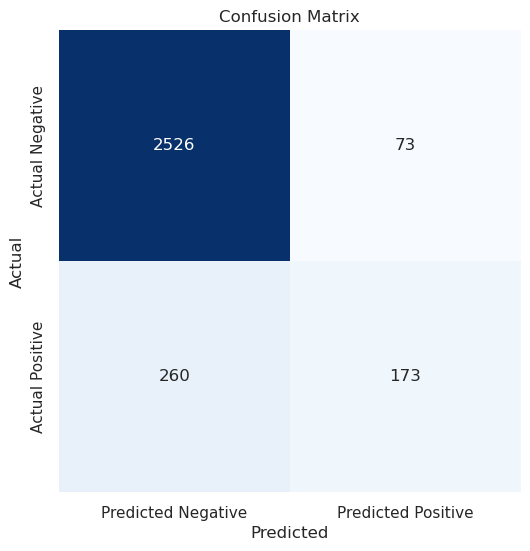

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
confusion = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True, 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Evaluate

In [17]:
from sklearn.metrics import classification_report
report = classification_report(y_test, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2599
           1       0.70      0.40      0.51       433

    accuracy                           0.89      3032
   macro avg       0.80      0.69      0.72      3032
weighted avg       0.88      0.89      0.88      3032



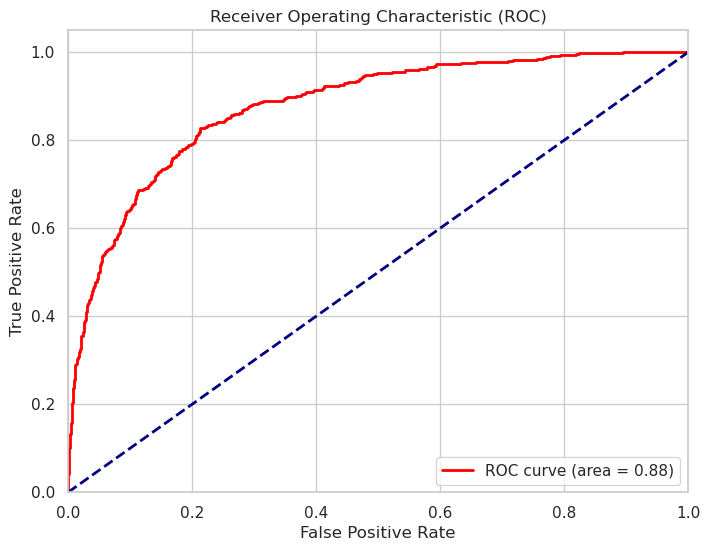

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [19]:
import numpy as np

# Example raw input values (replace these with actual values)
raw_input_values = {
    'Location': 'Sydney',
    'MinTemp': 20,
    'MaxTemp': 30,
    'Rainfall': 5,
    'WindGustDir': 'NW',
    'WindGustSpeed': 50,
    'WindDir9am': 'N',
    'WindDir3pm': 'NE',
    'WindSpeed9am': 20,
    'WindSpeed3pm': 30,
    'Humidity9am': 60,
    'Humidity3pm': 50,
    'Pressure9am': 1015,
    'Pressure3pm': 1010,
    'Temp9am': 25,
    'Temp3pm': 28,
    'RainToday': 'Yes'
}

# Preprocess the raw input data
def preprocess_input(raw_input_values):
    # Create a DataFrame from the raw input values
    input_df = pd.DataFrame([raw_input_values])

    # Perform preprocessing steps similar to training data
    input_df['RainToday_0'] = (input_df['RainToday'] == 'No').astype(int)
    input_df['RainToday_1'] = (input_df['RainToday'] == 'Yes').astype(int)
    
    # One-hot encode categorical variables
    input_df = pd.get_dummies(input_df, columns=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

    # Ensure all columns present in the training set are present in the input data
    missing_cols = set(X_train.columns) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = 0

    # Reorder columns to match the order used during training
    input_df = input_df[X_train.columns]

    return input_df

# Preprocess the raw input values
input_data = preprocess_input(raw_input_values)

# Predict the probability of rain
predicted_probability = model.predict_proba(input_data)[:, 1]

# Make a decision based on the predicted probability
if predicted_probability >= 0.5:
    print("There is a high probability of rain.")
else:
    print("There is a low probability of rain.")


There is a high probability of rain.
